In [1]:
%load_ext autoreload
%autoreload 2

# Gaussian process regression for forecasting battery state of health

Automotive industry has undergone significant changes with innovations like electrification and Autonomous Driving (ADAS). Electrificaiton, in general talks about many aspects but electrifying powertrain is the main focus area. Electrification is supposed to reduce the carbon footprint of vehicles, or at least isolate them away from cities where the major population resides around the world. According to this report from [EV Volumes](https://www.ev-volumes.com/country/total-world-plug-in-vehicle-volumes/) database, the YoY growth of EV sales showed average monotinic increasing trends despite the COVID situation economically.

<img src="https://www.ev-volumes.com/wp-content/uploads/2021/01/WW-A-12-2020.png" width="800" />


The Li-ion battery (LiB) technology is the backbone of electrified powertrain. A strong and reliable LiB technology entails early and robust adaptation of electrified powertrain. To that end, LiB development has many challenges. One among these is the prediction of Age of LiB cells as it is a multiscale and multiphysics problem at core. If the LiB cell capacity history is known, forecasting the State of Health (SoH) is a challenge, because this is governed by many external and user specific aspects. 

In this [paper](https://www.google.com/url?sa=t&rct=j&q=&esrc=s&source=web&cd=&cad=rja&uact=8&ved=2ahUKEwjqmJ_855bvAhUVgOYKHR4lByAQFjAAegQIBBAD&url=https%3A%2F%2Fwww.sciencedirect.com%2Fscience%2Farticle%2Fpii%2FS0378775317306250&usg=AOvVaw1P31v8I4zlOJacXNwqw_xP), the authors have tried to make use of Gaussian Process Regression (GPR) for this forecasting task. This notebook attempts to recreate the results from the paper. 

This 

#Table of content

Table of content

> 1. Basic Single Output GP Results
>> 1.1. Kernel Function Selection
>>
>>1.2. Kernel Function Decomposition
>>
>>1.3. Short-term Lookahead Prediction
>>
>>1.4 Remaining Useful Life Prediction
> 2. Encoding exponential degradation via EMFs Results
> 3. Capturing Cell-to-Cell Correlations via Multi-output GPs Results

Some imports relevant to this project

In [2]:
import numpy as np
import scipy.io as sio
import matplotlib.pyplot as plt
import pandas as pd

In [3]:
from gpr.Kernels import *
from gpr.GPR import GPR

## Data Exploration 

The degradation data for cells is stored in `data` folder. Make use of this function `read_capacity_data` to read in the degradation data from the csv files

In [4]:
def read_capacity_data(cell_name):
    cell_data = pd.read_csv('./data/'+cell_name+'.csv',header=None, names=['Time','Capacity'])
    return cell_data['Capacity'].values[:,np.newaxis], cell_data['Time'].values[:,np.newaxis]

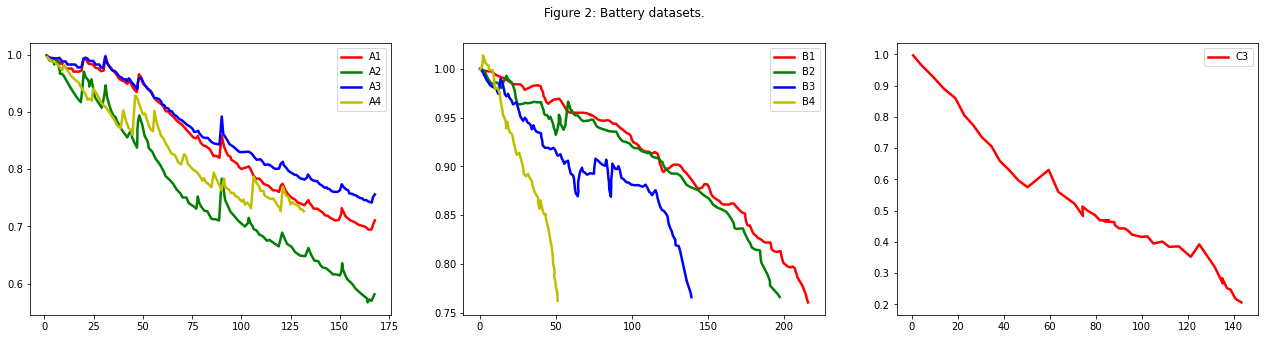

In [5]:
colors = ['r', 'g', 'b', 'y']
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(22,5))
fig.suptitle('Figure 2: Battery datasets.')

for i in range(4):
    capacity, time = read_capacity_data("A"+str(i+1))
    ax1.plot(time, capacity, colors[i], linewidth=2.5, label="A"+str(i+1))
    ax1.legend();

for i in range(4):
    capacity, time = read_capacity_data("B"+str(i+1))
    ax2.plot(time, capacity, colors[i], linewidth=2.5, label="B"+str(i+1))
    ax2.legend();

for i in range(1):
    capacity, time = read_capacity_data("C"+str(i+3))
    ax3.plot(time, capacity, colors[i], linewidth=2.5, label="C"+str(i+3))
    ax3.legend();

# Results 

## Basic Single Output GP Results

In [6]:
capacity, time = read_capacity_data('A1')

In [7]:
learn_till = 100
X = time[np.where(time<learn_till)][:,np.newaxis]
y = capacity[np.where(time<learn_till)][:,np.newaxis]

In [78]:
from sklearn.gaussian_process.kernels import ExpSineSquared, Matern, WhiteKernel, ExpSineSquared
from sklearn.gaussian_process import GaussianProcessRegressor

ma5 = Matern(length_scale=8e3,nu=5/2, length_scale_bounds=(1e-1, 5e3))
ma3 = Matern(length_scale=1e2,nu=3/2, length_scale_bounds=(1e-1, 5e2))
pe = ExpSineSquared(length_scale=1.0, periodicity=1.0, length_scale_bounds=(1e-05, 1e6), periodicity_bounds=(1e-05, 1e6))

kernel = ma5+ma3
gp = GaussianProcessRegressor(kernel=kernel,normalize_y=False, alpha=1e-5, n_restarts_optimizer=20)

gp.fit(X, y)

GaussianProcessRegressor(alpha=1e-05,
                         kernel=Matern(length_scale=8e+03, nu=2.5) + Matern(length_scale=100, nu=1.5),
                         n_restarts_optimizer=20)

In [76]:
x = np.atleast_2d(np.linspace(0,167,100)).T
y_pred, sigma = gp.predict(x, return_std=True)

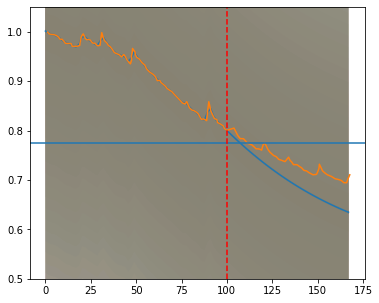

In [77]:
plt.figure(figsize=(6,5))
plt.plot(x, y_pred)
plt.fill(np.concatenate([x, x[::-1]]),np.concatenate([y_pred -  sigma,(y_pred + sigma)[::-1]]), alpha=0.1)
plt.plot(time, capacity)
plt.plot()
plt.ylim(0.5,1.05)
plt.axhline(y=0.775)
plt.axvline(x=learn_till, c='r', linestyle='--')

### Kernel Function Selection

### Kernel Function Decomposition

### Short-term Lookahead Prediction

### Remaining Useful Life Prediction

## Encoding exponential degradation via EMFs Results

## Capturing Cell-to-Cell Correlations via Multi-output GPs Results

In [43]:
capacity, time = read_capacity_data('A1')

In [44]:
learn_till = 100
X = time[np.where(time<learn_till)][:,np.newaxis]
y = capacity[np.where(time<learn_till)][:,np.newaxis]

In [106]:
kernel = Matern2_5(length_scale=100)
gpr = GPR(kernel=kernel)

In [60]:
success = gpr.optimize(X, y)

In [61]:
gpr.max_log_marginal_likelihood_value, gpr.kernel.length_scale

(-297.37829857435275, array([25.96124536]))

In [107]:
X_pred = np.atleast_2d(np.linspace(0,167,100)).T

In [108]:
mean, sigma = gpr.sample_posterior(X, y, X_pred)

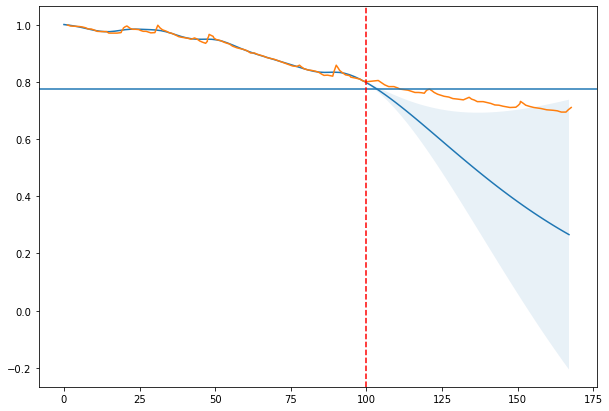

In [109]:
plt.figure(figsize=(10,7))
plt.plot(X_pred, mean)
plt.fill_between(X_pred[:,0],y_pred[:,0] -  sigma,y_pred[:,0] + sigma, alpha=0.1);
plt.plot(time, capacity)
# plt.ylim(0.4,1.1)
plt.axhline(y=0.775)
plt.axvline(x=learn_till, c='r', linestyle='--')

In [79]:
capacity, time = read_capacity_data('A1')

In [80]:
learn_till = 100
X = time[np.where(time<learn_till)][:,np.newaxis]
y = capacity[np.where(time<learn_till)][:,np.newaxis]

In [103]:
from sklearn.gaussian_process.kernels import ExpSineSquared, Matern, WhiteKernel, ExpSineSquared
from sklearn.gaussian_process import GaussianProcessRegressor

ma5 = Matern(length_scale=100,nu=5/2, length_scale_bounds=(1e-1, 5e3))
kernel = ma5
gp = GaussianProcessRegressor(kernel=kernel,normalize_y=False, alpha=1e-5, optimizer=None)

gp.fit(X, y)

GaussianProcessRegressor(alpha=1e-05, kernel=Matern(length_scale=100, nu=2.5),
                         optimizer=None)

In [104]:
y_pred, sigma = gp.predict(X_pred.reshape(-1,1), return_std=True)

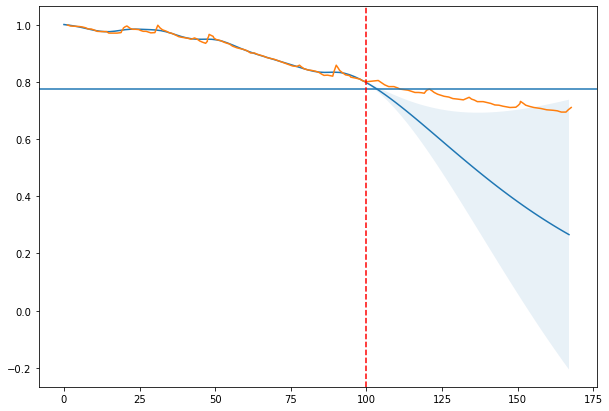

In [111]:
plt.figure(figsize=(10,7))
plt.plot(X_pred, y_pred)
plt.fill_between(X_pred[:,0],y_pred[:,0] -  sigma,y_pred[:,0] + sigma, alpha=0.1);
plt.plot(time, capacity)
# plt.ylim(0.5,1.05)
plt.axhline(y=0.775)
plt.axvline(x=learn_till, c='r', linestyle='--')